#Урок 6. Градиентный бустинг

__1 Задание.__

__Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом.
Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев).
Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).__

In [26]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

from sklearn.datasets import load_diabetes

import matplotlib.pyplot as plt

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
# Разделим выборку на обучающую и тестовую в соотношении 75/25
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
# Функция, реализующяя предсказание в градиентном бустинге
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
# В качестве функционала ошибки будем использовать среднеквадратичную ошибку
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
# Сдвиг
def bias(y, z):
    return (y - z)

In [8]:
# Функция обучения градиентного бустинга
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [24]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth}' 
          f' с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth}'
          f' с шагом {eta} на      тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [25]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на тренировочной выборке: 1095.988331326894
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1 на      тестовой выборке: 5393.7063167979395


Построим графики зависимости ошибки на обучающей и тестовой выборках от количества деревьев

In [27]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

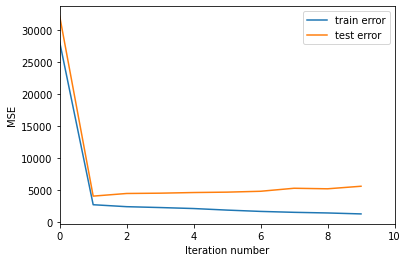

In [28]:
get_error_plot(n_trees, train_errors, test_errors)

In [29]:
# Увеличим максимальную глубину до 5
n_trees = 10

coefs = [1] * n_trees

max_depth = 5

eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [30]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 1 на тренировочной выборке: 175.76091311824302
Ошибка алгоритма из 10 деревьев глубиной 5 с шагом 1 на      тестовой выборке: 6204.719530715709


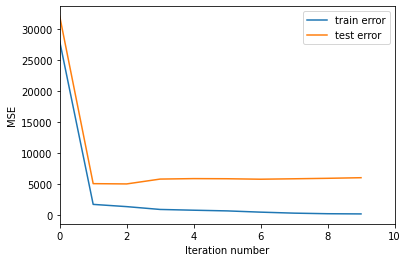

In [31]:
get_error_plot(n_trees, train_errors, test_errors)

При увеличении максимальной глубины до 5 переобучение модели усиливается, что видно по уменьшению ошибки в обучающей выборке и увеличению ее в тестовой выборке.

In [32]:
# Увеличим максимальную глубину до 10
n_trees = 10

coefs = [1] * n_trees

max_depth = 10

eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [33]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 10 с шагом 1 на тренировочной выборке: 4.057505592501788e-09
Ошибка алгоритма из 10 деревьев глубиной 10 с шагом 1 на      тестовой выборке: 8027.560187873652


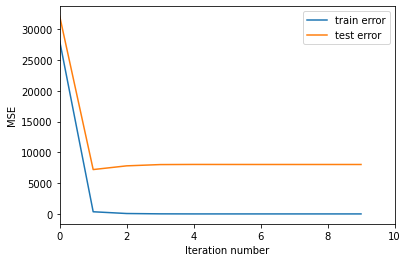

In [34]:
get_error_plot(n_trees, train_errors, test_errors)

При увеличении максимальной глубины до 10 переобучение модели резко возрастает.

In [35]:
# Уменьшим максимальную глубину до 2
n_trees = 10

coefs = [1] * n_trees

max_depth = 2

eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [36]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 2 с шагом 1 на тренировочной выборке: 1891.5815907079902
Ошибка алгоритма из 10 деревьев глубиной 2 с шагом 1 на      тестовой выборке: 4437.780371810982


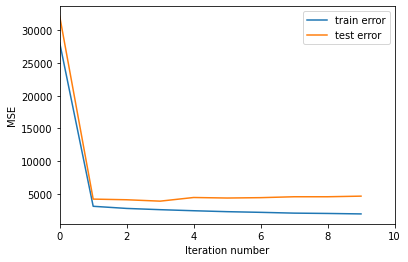

In [37]:
get_error_plot(n_trees, train_errors, test_errors)

При уменьшении максимальной глубины до 2 переобучение модели уменьшается по сравнению с исходным вариантом(в исходном варианте максимальная глубина=3).

In [38]:
# Уменьшим максимальную глубину до 1
n_trees = 10

coefs = [1] * n_trees

max_depth = 1

eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [39]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 1 с шагом 1 на тренировочной выборке: 2576.112019098052
Ошибка алгоритма из 10 деревьев глубиной 1 с шагом 1 на      тестовой выборке: 4263.694323036947


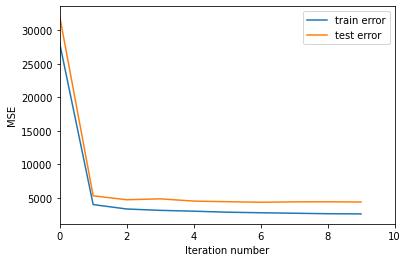

In [40]:
get_error_plot(n_trees, train_errors, test_errors)

При уменьшении максимальной глубины до 1 ошибка на обучающей выборке продолжает расти, а на тестовой выборке продолжает уменьшаться. Т.е. переобучение модели продолжает уменьшаться.

In [60]:
# Вернем максимальную глубину до 3 и уменьшим шаг градиента до 0,9
n_trees = 10

coefs = [1] * n_trees

max_depth = 3

eta = 0.9

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [61]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.9 на тренировочной выборке: 1290.379707953751
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.9 на      тестовой выборке: 4799.971793982123


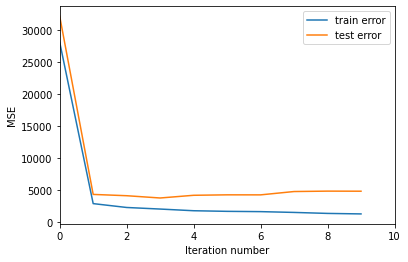

In [62]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь вернем максимальную глубину к исходным значениям(до 3) и уменьшим шаг градиента до 0,9. Переобучение модели уменьшается по сравнению с исходным вариантом.

In [66]:
# Уменьшим шаг градиента до 0,5
n_trees = 10

coefs = [1] * n_trees

max_depth = 3

eta = 0.5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [67]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.5 на тренировочной выборке: 1558.936044947805
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.5 на      тестовой выборке: 4269.910925898692


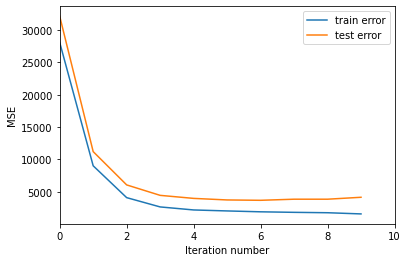

In [68]:
get_error_plot(n_trees, train_errors, test_errors)

Уменьшим шаг градиента до 0,5. Ошибка на обучающей выборке продолжает расти, а на тестовой выборке продолжает уменьшаться. Т.е. переобучение модели продолжает уменьшаться.

In [42]:
# Уменьшим шаг градиента до 0,1
n_trees = 10

coefs = [1] * n_trees

max_depth = 3

eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [43]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.1 на тренировочной выборке: 5526.650552832197
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.1 на      тестовой выборке: 7603.830088911324


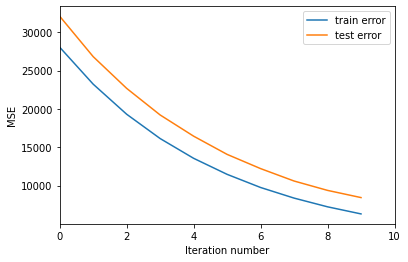

In [44]:
get_error_plot(n_trees, train_errors, test_errors)

Уменьшим шаг градиента до 0,1. Ошибка на обучающей и тестовой выборках возрастает, но переобучение модели остается на прежнем уровне.

In [45]:
# Уменьшим шаг градиента до 0,01
n_trees = 10

coefs = [1] * n_trees

max_depth = 3

eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [46]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.01 на тренировочной выборке: 23433.732029829236
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 0.01 на      тестовой выборке: 27111.44037051538


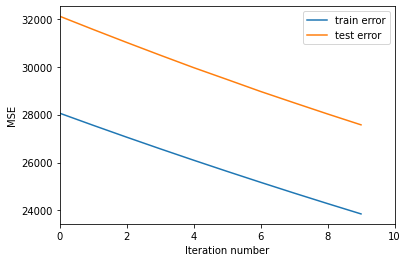

In [47]:
get_error_plot(n_trees, train_errors, test_errors)

Уменьшим шаг градиента до 0,01. Ошибка на обучающей и тестовой выборках резко возрастает.

In [51]:
# Увеличим шаг градиента до 1,5
n_trees = 10

coefs = [1] * n_trees

max_depth = 3

eta = 1.5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [52]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1.5 на тренировочной выборке: 1420.1425458452702
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 1.5 на      тестовой выборке: 6282.560792584272


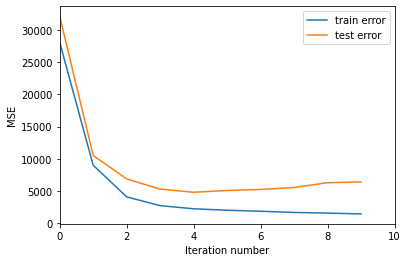

In [53]:
get_error_plot(n_trees, train_errors, test_errors)

Увеличим шаг градиента до 1,5. Ошибка на обучающей и тестовой выборках возрастает по сравнению с исходным случаем(шаг градиента=1), но переобучение модели остается на прежнем уровне.

In [54]:
# Увеличим шаг градиента до 2
n_trees = 10

coefs = [1] * n_trees

max_depth = 3

eta = 2

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [55]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 2 на тренировочной выборке: 28058.37160120853
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 2 на      тестовой выборке: 37791.13603376944


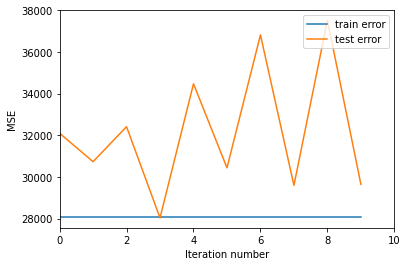

In [56]:
get_error_plot(n_trees, train_errors, test_errors)

Увеличим шаг градиента до 2. Ошибка на обучающей и тестовой выборках резко возрастает. При этом ошибка на обучающей выборке с увеличением количества деревьев не изменяется, а на тестовой то резко увеличивается,то резко уменьшается, в общем двигаясь в сторону увеличения. Т.е. переобучение модели растет.

In [57]:
# Увеличим шаг градиента до 5
n_trees = 10

coefs = [1] * n_trees

max_depth = 3

eta = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [58]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 5 на тренировочной выборке: 2.7902979985211504e+16
Ошибка алгоритма из 10 деревьев глубиной 3 с шагом 5 на      тестовой выборке: 3.016526598668677e+16


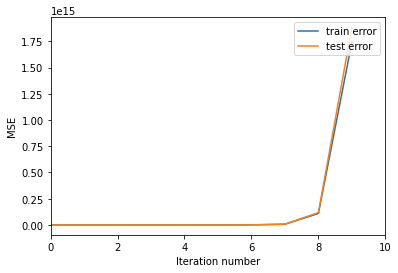

In [59]:
get_error_plot(n_trees, train_errors, test_errors)

Увеличим шаг градиента до 5. Ошибка на обучающей и тестовой выборках екстримально возрастает. При этом ошибка на обоих выборках с увеличением числа итераций возрастает, а после 8-ми итераций устремляется в рост под углом близким к 90. Переобучение с ростом числа деревьев возрастает.


Подберем оптимальные значения гиперпараметров (минимум ошибки на тесте при отсутствии переобучения):

In [134]:
# Алгоритм из 10-ти деревьев глубиной 2 с шагом 0,4 и коэффициентом 1,2:
n_trees = 10

coefs = [1.2] * n_trees

max_depth = 2

eta = 0.4

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [135]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 2 с шагом 0.4 на тренировочной выборке: 2066.6922835736
Ошибка алгоритма из 10 деревьев глубиной 2 с шагом 0.4 на      тестовой выборке: 3324.430757368282


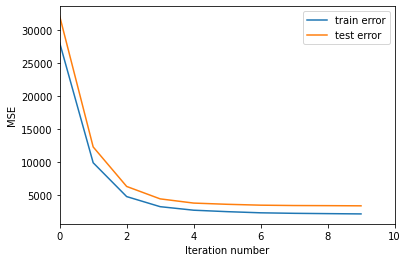

In [136]:
get_error_plot(n_trees, train_errors, test_errors)